In [26]:
import pandas as pd
import numpy as np
import joblib
import os
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, classification_report
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder
from datetime import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# Load and prepare data
clinical_df = pd.read_csv("../data/processed/train_ready/clinical_df_v1.csv", parse_dates=['timestamp'])
clinical_df.sort_values(['timestamp', 'patient_id'], inplace=True)
clinical_df.dropna(inplace=True)
clinical_df.drop(columns=['Unnamed: 0'], inplace=True)

In [31]:
len(clinical_df)

298992

In [28]:
clinical_df.columns

Index(['timestamp', 'puffs', 'district', 'longitude', 'latitude', 'station',
       'PM2.5 (µg/m³)', 'NO2 (µg/m³)', 'O3 (µg/m³)', 'patient_id', 'gender',
       'age', 'home_district', 'gema_severity', 'work_district',
       'symbicort_adherence', 'hour', 'is_night', 'is_peak_pollution',
       '24h_puffs', 'puffs_6h_diff', '3d_PM25_avg', '24h_PM25_avg',
       '24h_NO2_avg', '24h_O3_avg', 'PM25_exceedance', 'NO2_exceedance',
       'O3_exceedance', 'hospitalization', 'gema_risk_score', 'district_risk'],
      dtype='object')

### Target & Categorical features

In [ ]:
# 1. Create temporal target (hospitalization in next 24h)
clinical_df['target'] = clinical_df.groupby('patient_id')['hospitalization'].shift(-24)
clinical_df.dropna(subset=['target'], inplace=True)
clinical_df['target'] = clinical_df['target'].astype(int)

# 2. Categorical features treatment
# Gender (binary encoding)
clinical_df['gender_encoded'] = clinical_df['gender'].map({'F': 0, 'M': 1})

# Gema_severity (ordinal encoding)
ordinal_encoder = OrdinalEncoder(categories=[clinical_df['gema_severity'].unique()])
clinical_df['gema_severity_encoded'] = ordinal_encoder.fit_transform(clinical_df[['gema_severity']])

### Split data

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import resample

# 1. Sort by timestamp (critical for temporal splits)
clinical_df = clinical_df.sort_values('timestamp').reset_index(drop=True)

# 2. Define grouping variable (patients) and time threshold
TEST_SIZE = 0.2
TIME_CUTOFF = clinical_df['timestamp'].quantile(1-TEST_SIZE)

# 3. Temporal split - latest 20% period for test
test = clinical_df[clinical_df['timestamp'] >= TIME_CUTOFF]
train = clinical_df[clinical_df['timestamp'] < TIME_CUTOFF]

# 4. Balance training set (only on train data)
train_pos = train[train['target'] == 1]
train_neg = train[train['target'] == 0]

# Upsample positives to match 30% prevalence
desired_ratio = 0.3  # 30% positive class
n_pos = len(train_pos)
n_neg = int(n_pos * (1 - desired_ratio) / desired_ratio)
train_neg_balanced = resample(train_neg, n_samples=n_neg, replace=False, random_state=42)

train_balanced = pd.concat([train_pos, train_neg_balanced]).sample(frac=1, random_state=42)

# 5. Final validation split (time-based within train)
train_cutoff = train_balanced['timestamp'].quantile(0.8)
val = train_balanced[train_balanced['timestamp'] > train_cutoff]
train_final = train_balanced[train_balanced['timestamp'] <= train_cutoff]

print(f""" Data Split Summary: 
      - Training: {len(train_final)} samples ({len(train_final['patient_id'].unique())} patients)
      - Validation: {len(val)} samples ({len(val['patient_id'].unique())} patients)
      - Test: {len(test)} samples ({len(test['patient_id'].unique())} patients)

Class Distribution:
Training: {train_final['target'].value_counts(normalize=True).to_dict()}
Validation: {val['target'].value_counts(normalize=True).to_dict()}
Test: {test['target'].value_counts(normalize=True).to_dict()}
""")

 Data Split Summary: 
      - Training: 1672 samples (50 patients)
      - Validation: 418 samples (49 patients)
      - Test: 59840 samples (50 patients)

Class Distribution:
Training: {0: 0.7021531100478469, 1: 0.29784688995215314}
Validation: {0: 0.6913875598086124, 1: 0.30861244019138756}
Test: {0: 0.9945354278074866, 1: 0.005464572192513369}



### Training

Training until validation scores don't improve for 50 rounds
[100]	valid_0's average_precision: 0.85001
Early stopping, best iteration is:
[82]	valid_0's average_precision: 0.854788

Test Evaluation:
                    precision    recall  f1-score   support

No Hospitalization       1.00      0.94      0.97     59513
   Hospitalization       0.08      0.92      0.15       327

          accuracy                           0.94     59840
         macro avg       0.54      0.93      0.56     59840
      weighted avg       0.99      0.94      0.97     59840


AUPRC: 0.124
ROC-AUC: 0.969


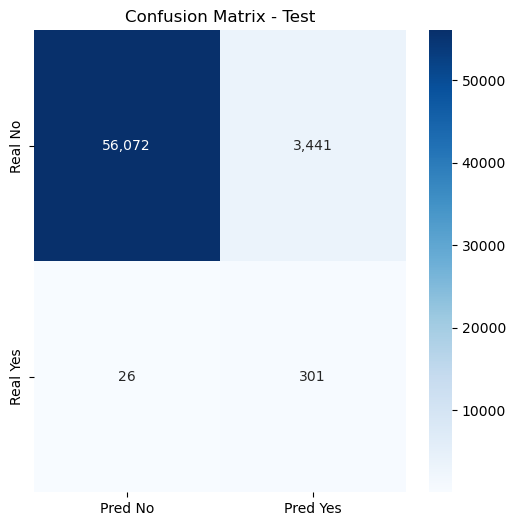

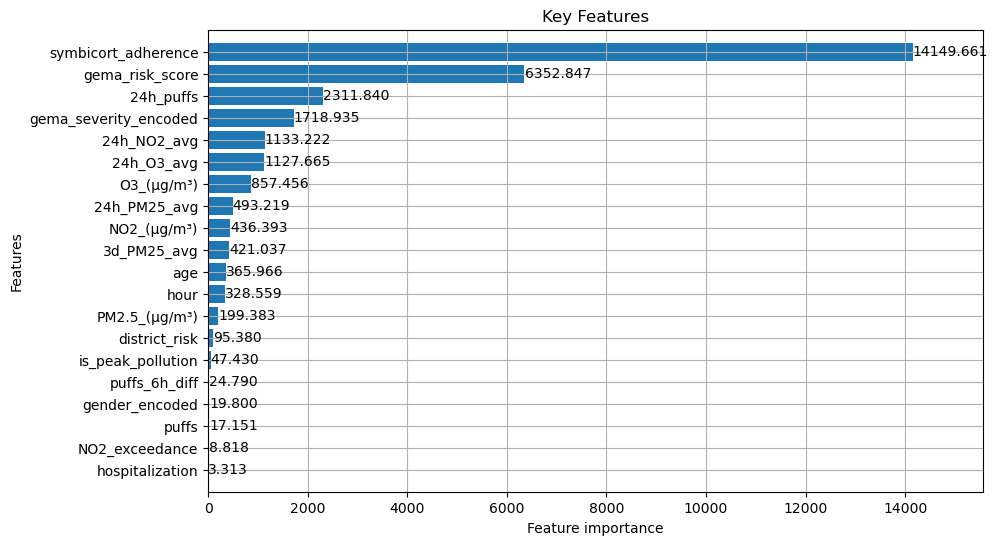

In [46]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Key features
features = ['puffs', 'PM2.5 (µg/m³)', 'NO2 (µg/m³)', 'O3 (µg/m³)',
       'gender_encoded', 'age', 'gema_severity_encoded', 'symbicort_adherence', 'hour', 'is_night', 
       'is_peak_pollution','24h_puffs', 'puffs_6h_diff', '3d_PM25_avg', '24h_PM25_avg',
       '24h_NO2_avg', '24h_O3_avg', 'PM25_exceedance', 'NO2_exceedance',
       'O3_exceedance', 'hospitalization', 'gema_risk_score', 'district_risk'
]

# 2. Configurate model parameters
params = {
    'objective': 'binary',
    'boosting_type': 'goss',
    'metric': 'average_precision',  # AUPRC for imbalanced data
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'scale_pos_weight': train_final['target'].value_counts()[0] / train_final['target'].value_counts()[1],  
    'seed': 42,
    'verbosity': -1
}

# 3. Create LightGBM Dataset with validation
train_data = lgb.Dataset(train_final[features], label=train_final['target'],feature_name=features,free_raw_data=False)

val_data = lgb.Dataset(val[features], label=val['target'],reference=train_data,free_raw_data=False)

# 4. Training with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ],
    num_boost_round=1000
)

# 5. Test evaluation
y_test_pred = model.predict(test[features])
y_test_class = (y_test_pred >= 0.5).astype(int)  # Umbral default

# 6. Key metrics
print("\nTest Evaluation:")
print(classification_report(test['target'], y_test_class, target_names=['No Hospitalization', 'Hospitalization']))

print(f"\nAUPRC: {average_precision_score(test['target'], y_test_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(test['target'], y_test_pred):.3f}")

# 7. Confusion Matrix
cm = confusion_matrix(test['target'], y_test_class)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', 
            xticklabels=['Pred No', 'Pred Yes'], 
            yticklabels=['Real No', 'Real Yes'])
plt.title('Confusion Matrix - Test')
plt.show()

# 8. Feature Importance
lgb.plot_importance(model, height=0.8, figsize=(10,6), importance_type='gain')
plt.title('Key Features')
plt.show()